![Logo 01](https://staff.utia.cas.cz/novozada/dizo/DIZO005.png)



**Course website:** [http://zoi.utia.cas.cz/ROZ1](http://zoi.utia.cas.cz/ROZ1)
    

# Part 0: Imports Packages & Data & Helper Functions

In [2]:
import requests
import zipfile
import os
import errno
import cv2 as cv
# For showing the images in Colab use wrap function cv2_imshow
from google.colab.patches import cv2_imshow
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
import time
import glob
import itertools
import os
from IPython import display
import math
import scipy
import warnings
warnings.filterwarnings("ignore")

filename = 'DIZO005_data.zip'
url = f'http://staff.utia.cas.cz/novozada/dizo/{filename}'
try:
    os.mkdir(f'{filename[:-4]}')
    r = requests.get(url, allow_redirects=True)
    open(filename, 'wb').write(r.content)
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall("")
except OSError as e:
    if e.errno != errno.EEXIST:
        raise
    else:
        print(f'{filename[:-4]} folder already exists!')

def resize(img, height=200, interpolation=cv.INTER_CUBIC):
  scale = height / img.shape[0]
  width = int(img.shape[1] * scale)
  new_size = (width, height)
  return cv.resize(img, new_size, interpolation = interpolation)

def show(img, height=200, interpolation=cv.INTER_CUBIC):
  img_new = resize(img, height, interpolation = interpolation)
  cv2_imshow(img_new)

def show_list(height, *imgs):
    show_more(height, *[cv.normalize(img, None, 0, 255, cv.NORM_MINMAX) for img in imgs])

def show_more(height, *args):
    img_new = cv.hconcat([resize(img, height).astype(float) for img in args])
    cv2_imshow(img_new)

def getFilenames(exts):
    fnames = [glob.glob(ext) for ext in exts]
    fnames = list(itertools.chain.from_iterable(fnames))
    fnames.sort()
    return fnames

# Part 1: Segmentation by Thresholding

Let's write a function `otsu(img)` that automatically binarizes the image for us, by finding the ideal threshold that divides the image into foreground and background.

We will be drawing from this paper -> [Otsu 1979](https://staff.utia.cas.cz/novozada/dizo/Otsu-paper.pdf)

We need a set of several functions first.

Write a function `discnorm(img, L)` that linearly transforms intensity values of the image to integer values from `1` to `L`.

*   default value `L = 256`
*   try it on **rice.png**

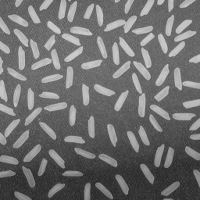

In [3]:
img_orig = cv.imread('rice.png', 0)
show(img_orig, 200)

Max values of original image = 204
Min values of original image = 40
Max values of transformed image = 256.0
Min values of transformed image = 1.0


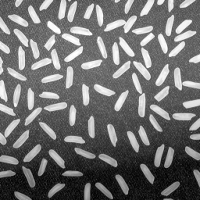

In [4]:
def discnorm(img, L=256):
  fmax = np.max(img)
  fmin = np.min(img)
  if fmax - fmin > 0:
    g = (img - fmin) / (fmax - fmin)
  else:
    g = np.zeros_like(img)
  g = 1 + np.round((L - 1) * g)
  return g

print(f'Max values of original image = {np.max(img_orig)}')
print(f'Min values of original image = {np.min(img_orig)}')

rice = discnorm(img_orig)

print(f'Max values of transformed image = {np.max(rice)}')
print(f'Min values of transformed image = {np.min(rice)}')

show(rice)

Write a function `histogram(img, L)` that calculates a histogram $h$ (i.e. a vector of brightness level frequencies) for the image.

*   default value `L = 256`
*   try it on **rice.png**



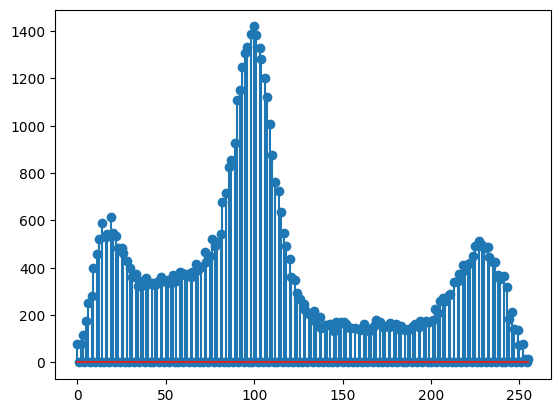

In [5]:
def histogram(img, L=256):
  hist, _ = np.histogram(img, bins=L)
  return hist

hist = histogram(rice)
plt.stem(hist)
plt.show()

Write a function `smoothhist(hist, r)` that smooths the histogram $h$ by convolving it with a rectangle of width $2*R+1$.

*   default value `L = 256`
*   try it on **temple.png**

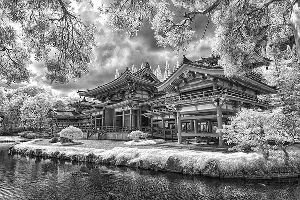

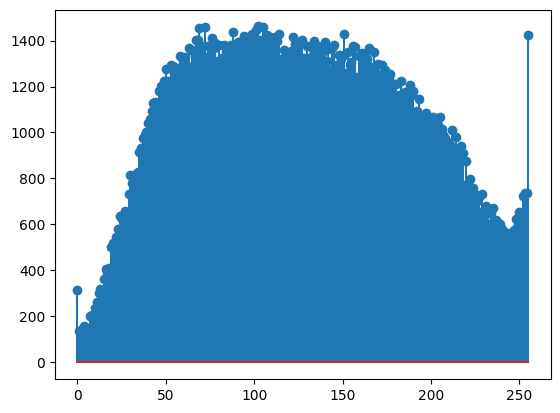

In [6]:
img_orig = cv.imread('temple.png', 0)
show(img_orig, 200)

hist = histogram(img_orig)
plt.stem(hist)
plt.show()

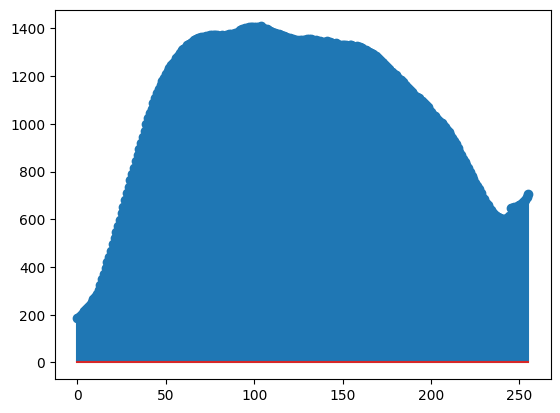

In [7]:
def smoothhist(hist, r):
  l = len(hist)
  m = np.ones(2 * r + 1)
  g = np.convolve(hist, m, mode='same')
  g /= np.convolve(np.ones(l), m, mode='same')
  return g

hist_smooth = smoothhist(hist, 10)
plt.stem(hist_smooth)
plt.show()

Now we can start programming the Otsu method.

Open the PDF and follow the steps.

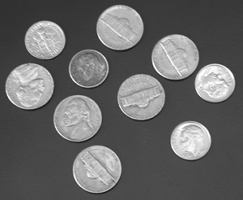

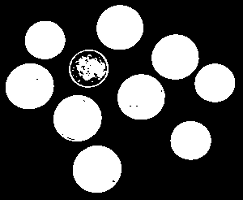

In [8]:
def otsu(img, L=256):
  # linear luminance transformation
  img = discnorm(img, L)
  # number of pixels
  N = img.shape[0] * img.shape[1]
  # brightness levels (histogram)
  n = histogram(img, L)
  # brightness probability density
  p = n / N
  # brightness distribution function (probability of class w0)
  w = np.cumsum(p)
  # 1st order cumulative moment
  m = np.cumsum(np.arange(1, L+1) * p)
  # mean brightness value
  mT = m[-1]
  # inter-class variance
  sB = np.power((mT * w - m), 2) / (w * (1 - w))
  # zero division treatment
  sB[(w * (1 - w)) == 0] = 0
  # threshold maximising sB
  tt = np.argmax(sB) + 1
  # final image
  g = (img >= tt)
  return g.astype(np.uint8()), tt

img_orig = cv.imread('coins.png', 0)
show(img_orig, 200)

coins_otsu,_ = otsu(img_orig)
show(coins_otsu*255, 200)

Try the Otsu algorithm on **morse.png**:

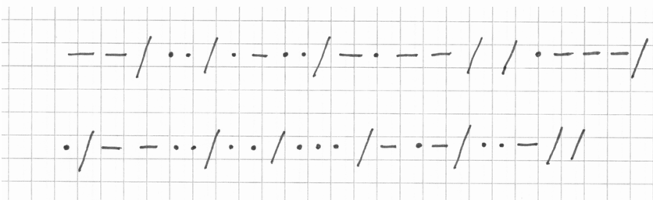

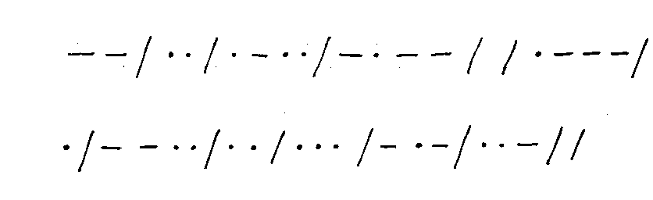

In [9]:
img_orig = cv.imread('morse.png', 0)
show(img_orig, 200)

morse_otsu, _ = otsu(img_orig)
show(morse_otsu*255, 200)

Try the Otsu algorithm on **rice.png**:

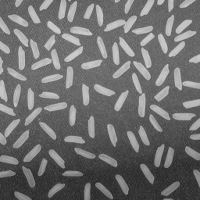

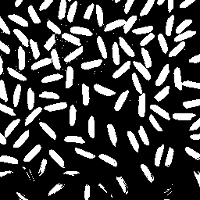

In [10]:
img_orig = cv.imread('rice.png', 0)
show(img_orig, 200)

rice_otsu, _ = otsu(img_orig)
show(rice_otsu*255, 200)

You don't like the result either? So what do you suggest?
*   Split the image into tiles and calculate local thresholding in each tile.

Write a function `otsu_local(img, n1, n2, L)` which evenly divides the image into $n_1 \times n_2$ rectangles. Then binarize these parts locally using the Otsu method.

*   default value `L = 256`
*   try it on **rice.png**

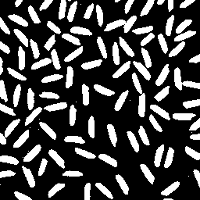

In [11]:
def otsu_local(img, n1, n2, L = 256):
  d1 = np.floor(np.arange(n1+1) * img.shape[0] / n1)
  d2 = np.floor(np.arange(n2+1) * img.shape[1] / n2)
  d1 = d1.astype(int)
  d2 = d2.astype(int)
  g = np.zeros_like(img)
  for i in np.arange(len(d1)-1):
    for j in np.arange(len(d2)-1):
      temp, _ = otsu(img[d1[i]:d1[i+1], d2[j]:d2[j+1]])
      g[d1[i]:d1[i+1], d2[j]:d2[j+1]] = temp
  return g

img_orig = cv.imread('rice.png', 0)
rice_otsu_local = otsu_local(img_orig, 8, 8)
show(rice_otsu_local*255)

Sometimes you want to segment an object whose intensities are between two thresholds >>

Write a function `bandthreshold(img, t1, t2)` that binarizes the image by selecting pixels with intensity values in the interval $<t_1, t_2>$ as the object and the rest as background.

*   default value `t2 = 256`
*   try it on **saturn.png**

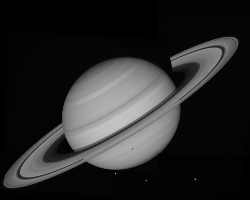

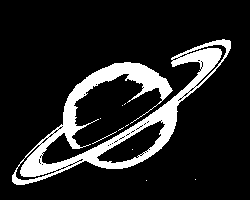

In [12]:
def bandthreshold(img, t1, t2=255):
  g = (img >= t1) * (img <= t2)
  return g.astype(np.uint8())

img_orig = cv.imread('saturn.png', 0)
show(img_orig, 200)

saturn = bandthreshold(img_orig, 100, 150)
show(saturn*255, 200)

In some cases, you know that the foreground takes up a certain percentage of the overall picture.

Write a function `ptile(img, p)` that binarizes the image using a threshold $t$ so that its histogram area is divided in a ratio of `p` to `1-p`:

*   $p\in <0, 1>$
*   this method is very effective for printed text
*   try it on **paragraph.png**

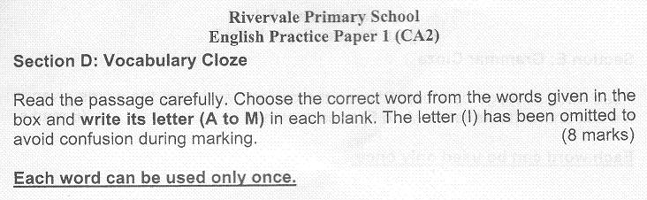

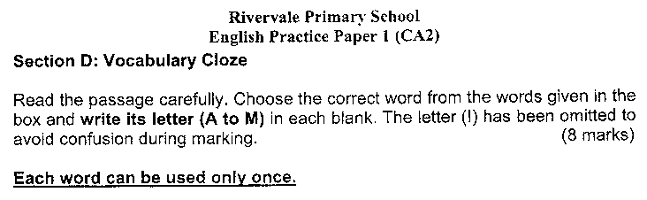

In [13]:
def ptile(img, p):
  h = histogram(img)
  c = np.cumsum(h)
  n = c[-1]
  t = np.where(c >= n * p)[0][0]
  g = img >= t
  return g.astype(np.uint8())

img_orig = cv.imread('paragraph.png', 0)
show(img_orig, 200)

paragraph_ptile = ptile(img_orig, 0.08)
show(paragraph_ptile*255, 200)

Try `ptile` on **morse.png**:

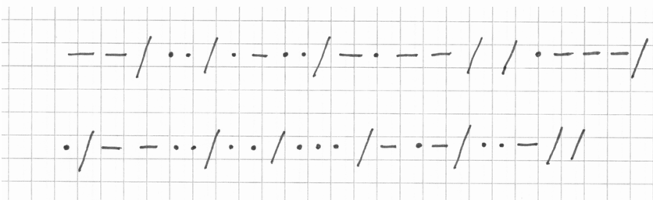

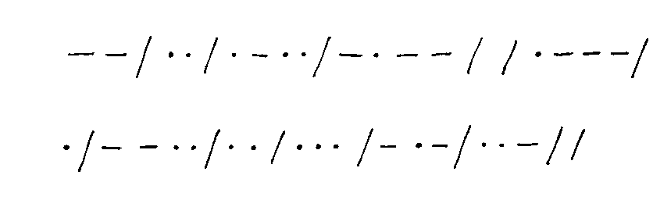

In [14]:
img_orig = cv.imread('morse.png', 0)
show(img_orig, 200)

morse_ptile = ptile(img_orig, 0.018)
show(morse_ptile*255, 200)

Write a function `semithreshold(img, t)` that selects pixels with intensity values below the threshold `t` as background, while leaving the values of other pixels unchanged:

*   try it on **moon.png**

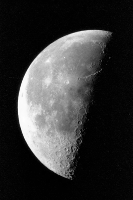

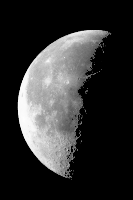

In [15]:
def semithreshold(img, t=128):
  m = img >= t;
  g = img * m;
  return g.astype(np.uint8())

img_orig = cv.imread('moon.png', 0)
show(img_orig, 200)

moon_semi = semithreshold(img_orig, 80)
show(moon_semi, 200)

In the color image **columns.png**, change the sky pixels to **black**.

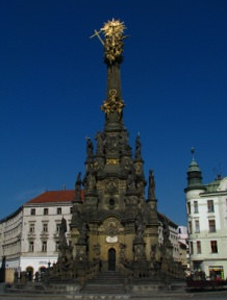

In [16]:
img_orig = cv.imread('sloup.png', 1)
show(img_orig, 300)

Split the channels:

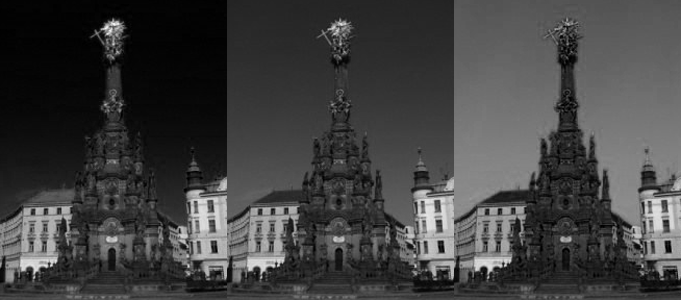

In [17]:
b,g,r = cv.split(img_orig)
show_more(300, r, g, b)

Use the Otsu method as mask to differentiate between the red and blue channels:

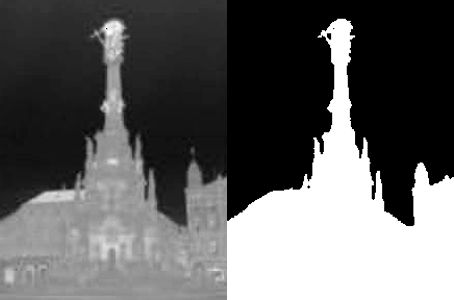

In [18]:
rb = r.astype(np.float16()) - b.astype(np.float16())
rb = discnorm(rb).astype(np.uint8())
[m, t] = otsu(rb)
show_more(300, rb, m*255)

Use the mask for all three channels and merge them back into a color image:

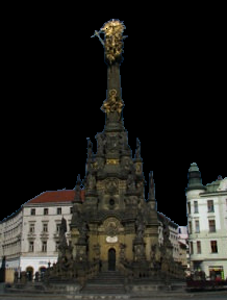

In [19]:
r = r * m
g = g * m
b = b * m
img_final = cv.merge([b,g,r])
show(img_final, 300)

Extract the texture area in the semicircle at the bottom, from the **texture.png** image. Try using local variance as a feature.

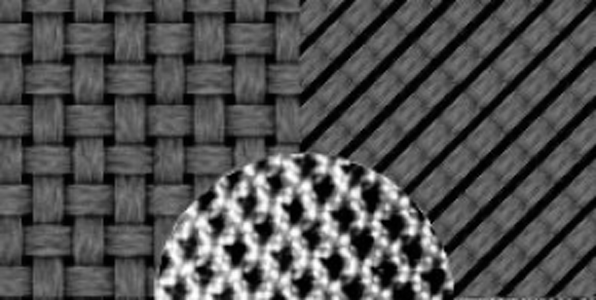

In [20]:
img_orig = cv.imread('texture.png', 0)
show(img_orig, 300)

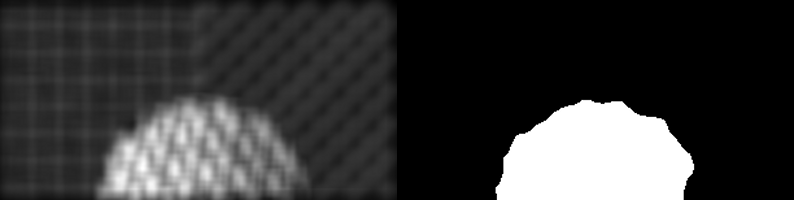

In [21]:
temp = discnorm(img_orig)
r = 8
m = np.ones((2*r+1, 2*r+1)) / ((2*r+1)^2)
EX = cv.filter2D(temp, ddepth=cv.CV_32F, kernel=m, borderType=cv.BORDER_CONSTANT)
EX2 = cv.filter2D(np.power(temp,2), ddepth=cv.CV_32F, kernel=m, borderType=cv.BORDER_CONSTANT)
varX = EX2 - np.power(EX,2)
varX = discnorm(EX2)
texture_otsu, _ = otsu(varX)

kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (30,30))
texture_otsu = cv.morphologyEx(texture_otsu.astype(np.uint8), cv.MORPH_CLOSE, kernel)

show_more(200, varX, texture_otsu*255)

# Part 2: Object Recognition

**Motivation:**
- recognition is the act of deciding whether an object belongs to a given class
- the object is described by a set of attributes (n-D vector in metric space)


**What types of classification/recognition do we know?**
- supervised recognition (with learning) - we have a typical set of representatives (training set) for all classes
- unsupervised recognition (without learning) - we neither have a training set nor know how many classes there are

<img src="https://staff.utia.cas.cz/novozada/dizo/recognition001.jpg">

**Training set:**
- representative-typical samples of the class, all major types, there should be no other samples
- large enough - to capture internal variability
- should be compiled by an expert in the field

**Formal definitions of classifiers:**
- each class is characterized by a discriminant function $𝑔(𝑥)$
- classification = maximization of $𝑔(𝑥)$

**More about classifiers:**
follow-up course: [http://zoi.utia.cas.cz/SU1](http://zoi.utia.cas.cz/SU1)
    

## Fourier descriptors

- belongs to the group of transformation coefficients

- based on **Fourier shift theorem** (FST):
$$
\begin{aligned}
𝓕[f(x-x_0)](k) = e^{-2\pi i kx_0}𝓕(k)
\end{aligned}
$$

 - The fourier transform of the shifted function is just a multiple of the fourier transform of the original one.
 - The FT amplitude does not change during the shift, the phase shifts in a defined way.

**How will the FST be used ?**

1.   First we construct a radial function:
<img src="https://staff.utia.cas.cz/novozada/dizo/recognition002.jpg">

2.   The radial function is invariant to:
  - ***shift*** - we relate it to the centre of gravity, we don't have to consider displacement
  - ***rotation*** - the radial function will only shift - so it does not depend on the starting point

3. We calculate FT of the radial function and take its amplitude - we declare the first few coefficients of the FT as our searched *FOURIER DESCRIPTORS*

To ensure invariance to scaling, this set is divided by the first coefficient, which is the coefficient of the constant function - or the mean.

$$
\begin{aligned}
𝓕(k) = \int f(x)e^{-2\pi i kx}dx
\end{aligned}
$$
$$
\begin{aligned}
𝓕(0) = \int f(x)dx
\end{aligned}
$$

### Application in practice (discrete case):

1.   Take the boundary and rewrite it as a complex function:
$$
\begin{aligned}
f(t) = x(t) + iy(t)
\end{aligned}
$$
2.   Calculate its FT and take the absolute values
3.   The zero coefficient now has a different meaning - it tells us the distance from the origin, so we discard it and use the other ones

*Note: There isn't a lot of information in FD - much of the information in FT is contained in the phase which we don't consider at all.*


### EXAMPLE:
Use the **ocr.png** image to demonstrate the Fourier descriptors.

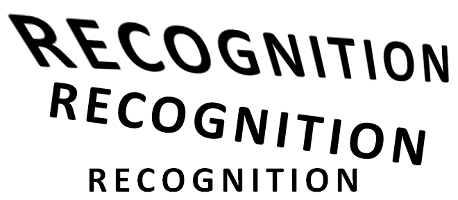

In [22]:
img_orig = cv.imread('ocr.png')
show(img_orig, 200)

####  Image preprocessing


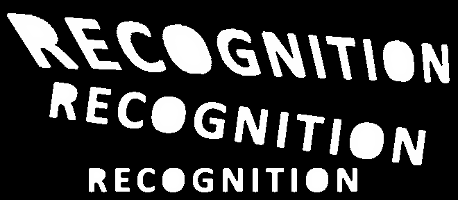

In [23]:
# Read the image
img_orig = cv.imread('ocr.png')
# create the working copy
img = img_orig.copy()
# convert to the grayscale
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img = img.astype(np.uint8)
# do the threshold
img = img < 255

# now use the morphology operations to clear the image
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3,3))
# closing
img = cv.morphologyEx(img.astype(np.uint8), cv.MORPH_CLOSE, kernel)

# Fourier descriptors can handle only stars objects
h, w = img.shape[:2]
# create the mask with zeros
mask = np.zeros((h+2, w+2), np.uint8)
# Floodfill all holes in the binary image
cv.floodFill(img, mask, (0,0), 255);
#  invert the image
img = cv.bitwise_not(img)
# show the final output
show(img, 200)

####  Detect contours

Use the [`findContours()`](https://docs.opencv.org/4.x/d4/d73/tutorial_py_contours_begin.html) function from the OpenCV library.

In [24]:
contours, _ = cv.findContours(img.astype(np.uint8), mode=cv.RETR_LIST, method=cv.CHAIN_APPROX_NONE)
print(f'There are {len(contours)} letters')

There are 33 letters


Write a function that can display specific letters for testing purposes.

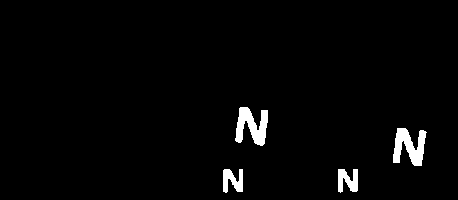

In [25]:
def show_instance(img, contours, nums):
  # create a black image of the same size as the image with letters
  out = np.zeros_like(img)
  # paint the selected polygons
  for num in nums:
    cv.fillPoly(out, [contours[num]], 255)
  # show the output
  show(out, interpolation=cv.INTER_NEAREST)

show_instance(img, contours, [0, 5, 11, 16])

Show the last letter:

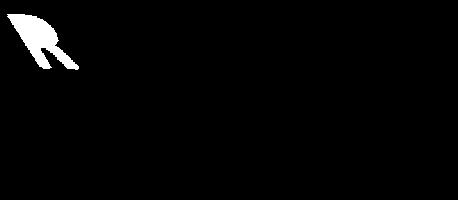

In [26]:
show_instance(img, contours, [len(contours)-1])

How to make the border our desired complex function?

In [27]:
temp = contours[32]
print(f'The shape of contour: {temp.shape}')
contour_array = temp[:, 0, :]
temp = temp[:,0,0] + temp[:,0,1]*1j
print(f'The first compex number = {temp[0]}')

The shape of contour: (309, 1, 2)
The first compex number = (11+19j)


Finally, we can write our function for calculating FD:

In [28]:
def  fourier_descriptors(contours, num):
  # create the zeros matrix - num(rows)...num of contours x num(cols)...num of FD
  fd = np.zeros((len(contours), num))
  # go through all the contours
  for idx, contour in enumerate(contours):
    # create the complex function from the border
    contour_complex = contour[:,0,0] + contour[:,0,1]*1j
    # apply the FT and count the amplitude
    ft_contour = np.abs(np.fft.fft(contour_complex))
    # take Fourier coefficients from the second one and normalize them with the length of the border
    fd[idx, :] = ft_contour[1:num+1] / (len(ft_contour)**2)
  return fd

FD = fourier_descriptors(contours, 10)

####  Playing with FD

What FDs look like:

[0.03970618 0.02015829 0.01996365 0.00536544 0.00313159 0.003661
 0.00243421 0.00216483 0.0007529  0.00060523]


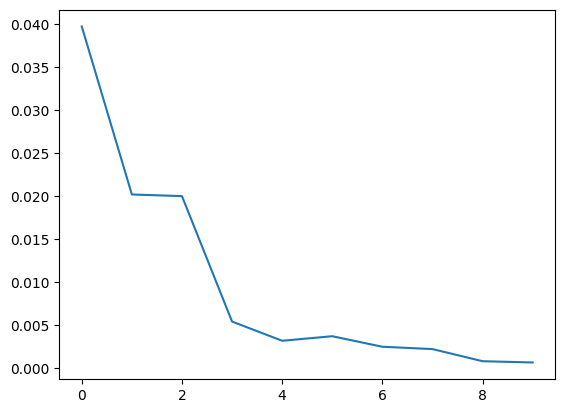

In [29]:
print(FD[32,:])
plt.plot(FD[32,:])

What would it be for a square?

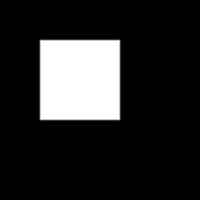

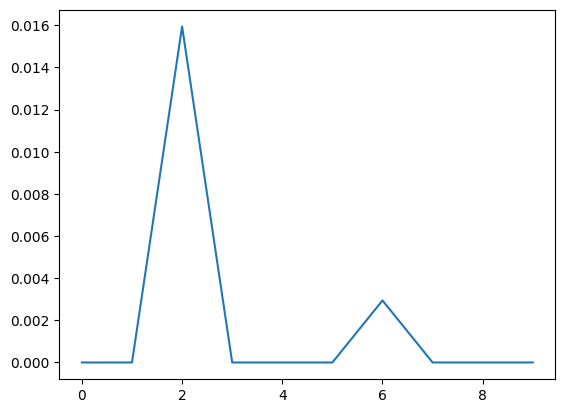

In [30]:
sq1 = np.zeros((100,100))
sq1[20:60, 20:60] = 255
show(sq1)
contours_square1, _ = cv.findContours(sq1.astype(np.uint8), mode=cv.RETR_LIST, method=cv.CHAIN_APPROX_NONE)
FD_square1 = fourier_descriptors(contours_square1, 10)
plt.plot(FD_square1[0,:]);

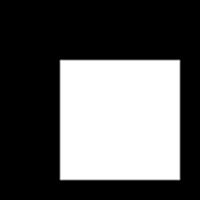

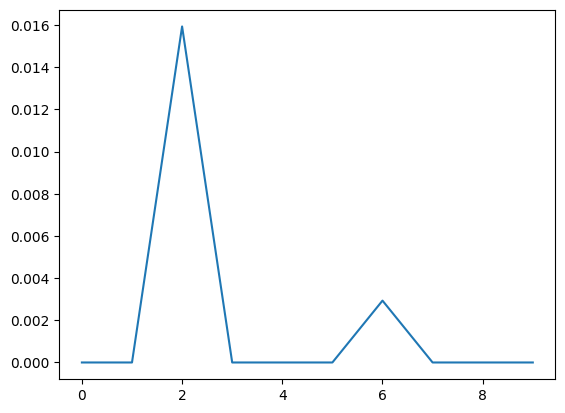

In [31]:
sq2 = np.zeros((100,100))
sq2[30:90, 30:90] = 255
show(sq2)
contours_square2, _ = cv.findContours(sq2.astype(np.uint8), mode=cv.RETR_LIST, method=cv.CHAIN_APPROX_NONE)
FD_square2 = fourier_descriptors(contours_square2, 10)
plt.plot(FD_square2[0,:]);

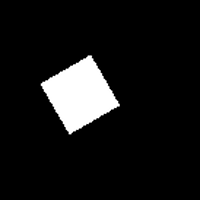

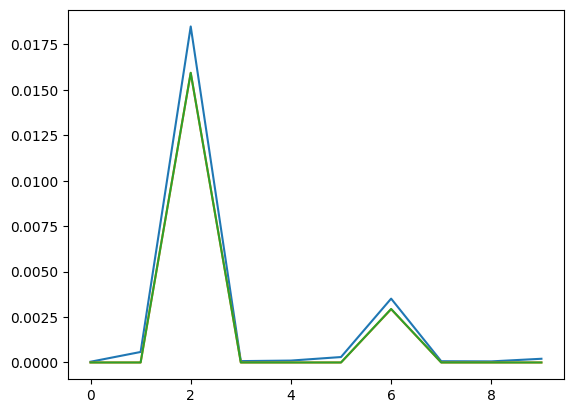

In [32]:
sq3 = ndimage.rotate(sq1, 30, cval=0)
_, sq3 = cv.threshold(sq3,127,255,cv.THRESH_BINARY)
contours_square3, _ = cv.findContours(sq3.astype(np.uint8), mode=cv.RETR_LIST, method=cv.CHAIN_APPROX_NONE)
FD_square3 = fourier_descriptors(contours_square3, 10)
show(sq3)

# show all graphs together
plt.plot(FD_square3[0,:]);
plt.plot(FD_square2[0,:]);
plt.plot(FD_square1[0,:]);

What about a rectangle?

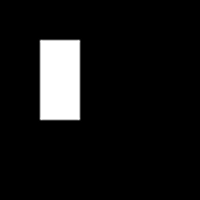

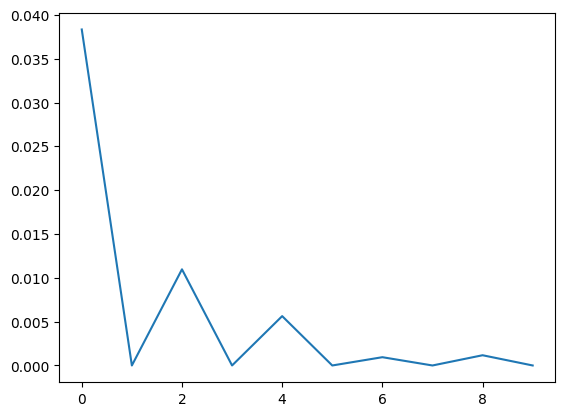

In [33]:
rec1 = np.zeros((100,100))
rec1[20:60, 20:40] = 255
show(rec1)
contours_rec1, _ = cv.findContours(rec1.astype(np.uint8), mode=cv.RETR_LIST, method=cv.CHAIN_APPROX_NONE)
FD_rec1 = fourier_descriptors(contours_rec1, 10)
plt.plot(FD_rec1[0,:]);

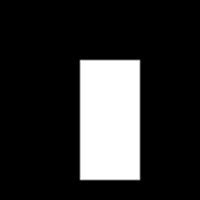

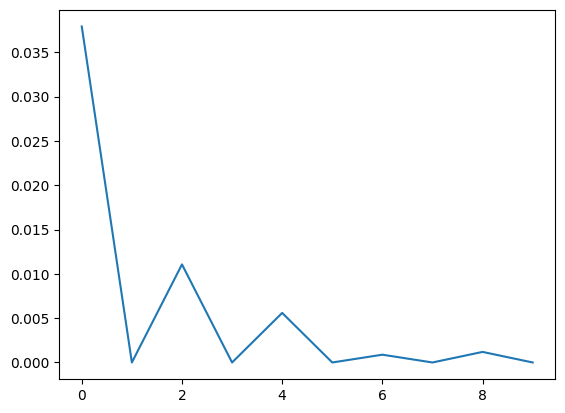

In [34]:
rec2 = np.zeros((100,100))
rec2[30:90, 40:70] = 255
show(rec2)
contours_rec2, _ = cv.findContours(rec2.astype(np.uint8), mode=cv.RETR_LIST, method=cv.CHAIN_APPROX_NONE)
FD_rec2 = fourier_descriptors(contours_rec2, 10)
plt.plot(FD_rec2[0,:]);

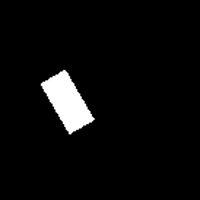

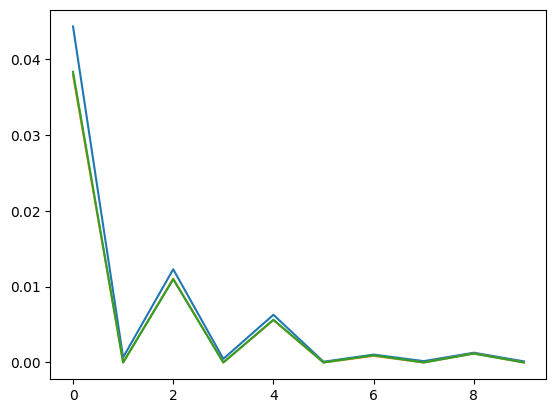

In [35]:
rec3 = ndimage.rotate(rec1, 30, cval=0)
_, rec3 = cv.threshold(rec3,127,255,cv.THRESH_BINARY)
contours_rec3, _ = cv.findContours(rec3.astype(np.uint8), mode=cv.RETR_LIST, method=cv.CHAIN_APPROX_NONE)
FD_rec3 = fourier_descriptors(contours_rec3, 10)
show(rec3)

# show all graphs together for rectangles
plt.plot(FD_rec3[0,:]);
plt.plot(FD_rec2[0,:]);
plt.plot(FD_rec1[0,:]);

#### Let's go back to our letters

Show the feature space for the first few combinations:

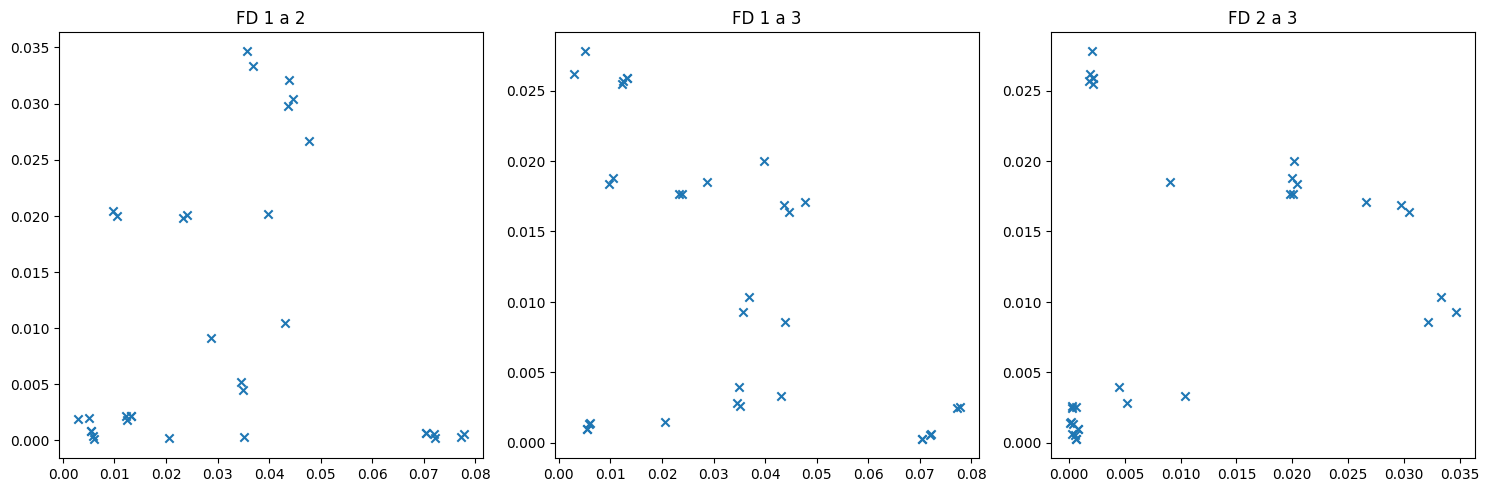

In [36]:
fig, axis = plt.subplots(1, 3)
fig.set_size_inches((15,5))
axis[0].scatter(FD[:,0], FD[:,1], marker='x')
axis[0].set_title("FD 1 a 2")

axis[1].scatter(FD[:,0], FD[:,2], marker='x')
axis[1].set_title("FD 1 a 3")

axis[2].scatter(FD[:,1], FD[:,2], marker='x')
axis[2].set_title("FD 2 a 3")
fig.tight_layout(pad=1.0)
plt.show()

Use the L2-norm for counting all distances >> create the distance matrix.

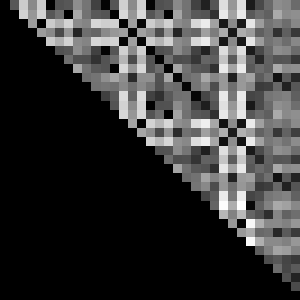

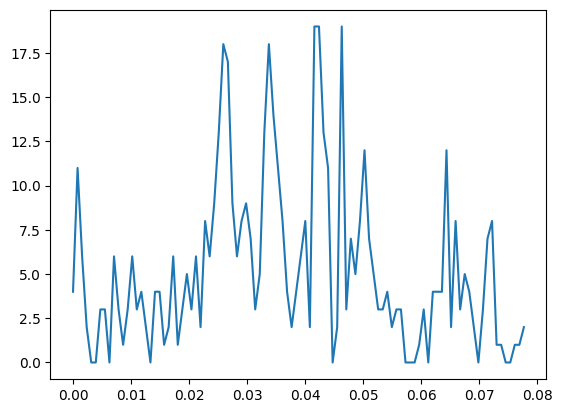

In [37]:
def distance_matrix(vectors):
  n = vectors.shape[0]
  dm = np.zeros((n, n))
  for i in range(n):
    for j in range(i+1,n):
      dm[i, j] = np.linalg.norm(vectors[i,:] - vectors[j,:])
  return dm

dm = distance_matrix(FD)
show(dm*(255/np.max(dm)),300, interpolation=cv.INTER_NEAREST)

# the histogram of the distance matrix
histogram, bins = np.histogram(dm[dm > 0], bins=100)
plt.plot(bins[0:-1], histogram)
plt.show()

Now we can threshold the distances:

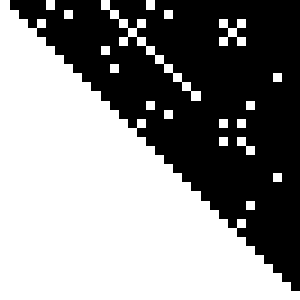

In [38]:
show((dm<0.008)*255,300, interpolation=cv.INTER_NEAREST)

Show the palette:


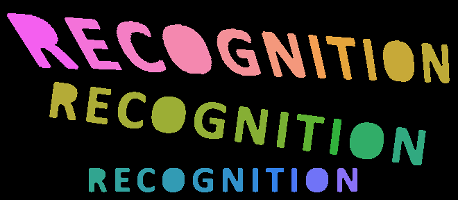

Coloring similar letters:


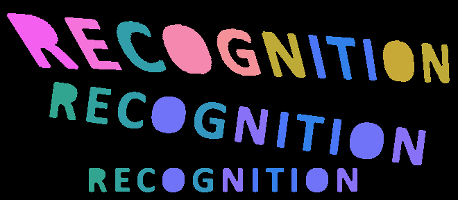

In [39]:
import seaborn as sns

def show_classes(img, contours, dm):
  n = dm.shape[0]
  out = np.zeros_like(img)
  out = cv.merge((out, out, out))
  palette = sns.color_palette("husl", n+5)
  for i in range(n):
    cv.fillPoly(out, [contours[i]], [x * 255 for x in palette[i]])
  print('Show the palette:')
  show(out)
  for i in range(n):
    for j in range(i+1, n):
      if dm[i,j]:
        cv.fillPoly(out, [contours[j]],  [x * 255 for x in palette[i]])
        dm[j,:] = 0
  print('Coloring similar letters:')
  show(out)

show_classes(img, contours, dm<0.008)

As we can see rotation and scaling have no effect on FD >> compare the 2th and 3rd line.

However, geometric transformations have a fatal effect on most letters >> 1st line.

## Moment invariants

Moments are the projection of the image function onto a polynomial basis.

**General moment of a picture:**
$$
\begin{aligned}
M_{pq}(f) = \iint_D p_{pq}(x,y)f(x,y) \,dx\,dy
\end{aligned}
$$


*   $p,q \in 𝜨^+ $
*   $r=p+q$ is the degree of a moment
*   $p_{00}(x,y), p_{10}(x,y), ...,p_{kj}(x,y)$ is the polynomial basis of the functions defined on $D$



### Central Geometric Moment

$$
\begin{aligned}
\mu_{pq} = \iint_{-∞}^∞ (x-x_t)^p(y-y_t)^qf(x,y) \,dx\,dy
\end{aligned}
$$


*   where $x_t=\frac{m_{10}}{m_{00}}$ and $y_t=\frac{m_{01}}{m_{00}}$

#### Invariant to rotation
**M.K.Hu,1962** - 7 invariants of the third order:

<img src="https://staff.utia.cas.cz/novozada/dizo/hu.png">


They are hard to find, but easy to prove. If we plug in the transformation relations for rotation:

$$
\begin{aligned}
x' = x\,cos\,θ - y\,sin\,θ \\
y' = x\,sin\,θ - y\,cos\,θ
\end{aligned}
$$

**They are not ideal:**

*   Dependence: $𝛷_3=\frac{𝛷_5^2+𝛷_7^2}{𝛷_4^3}$
*   Incompleteness



### EXAMPLE:
Use the **ocr.png** image to demonstrate the Hu's moments - use the [`HuMoments()`](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#ga6d6ac1b519cba25190119afe3a52c1cc) function from the OpenCV library.

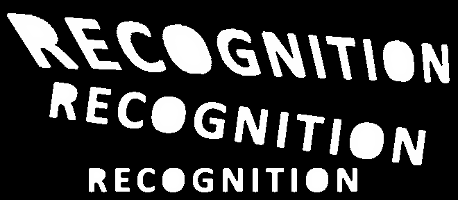

In [40]:
show(img, 200)

In [41]:
def hu_moments(img, contours):
  # create the zeros matrix - num(rows)...num of contours x num(cols)...num of FD
  hm = np.zeros((len(contours), 7))
  # go through all the contours
  for idx, contour in enumerate(contours):
    temp = np.zeros_like(img)
    # paint the selected polygons
    cv.fillPoly(temp, [contour], 255)
    # Calculate Moments
    moments = cv.moments(temp)
    # Calculate Hu Moments
    hm[idx, :] = np.squeeze(cv.HuMoments(moments))
  return hm

HM = hu_moments(img, contours)

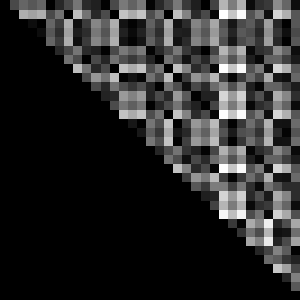

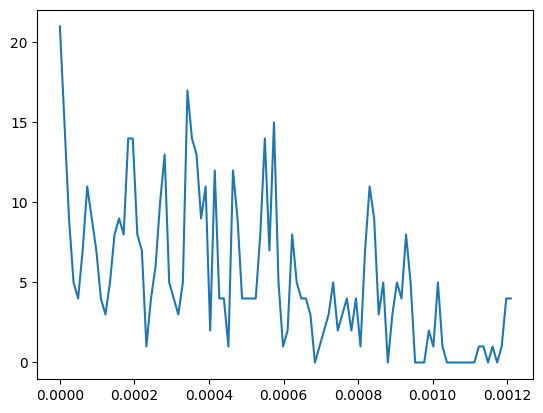

In [42]:
dm_hm = distance_matrix(HM)
show(dm_hm*(255/np.max(dm_hm)),300, interpolation=cv.INTER_NEAREST)
# the histogram of the distance matrix
histogram, bins = np.histogram(dm_hm[dm_hm > 0], bins=100)
plt.plot(bins[0:-1], histogram)
plt.show()

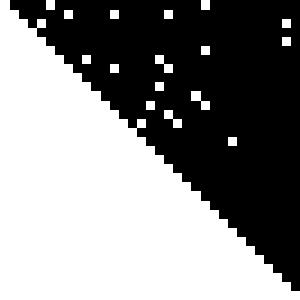

In [43]:
show((dm_hm<0.00001)*255,300, interpolation=cv.INTER_NEAREST)

Show the palette:


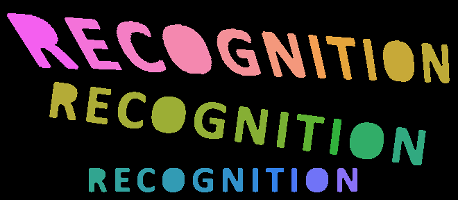

Coloring similar letters:


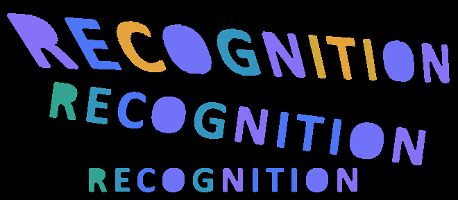

In [44]:
show_classes(img, contours, (dm_hm<0.0001))

# Part 3: Homework

## ✍🏼 Homework 005.1

Write a program that automatically counts the number of nails, screws and wooden blocks. As you can see from the picture, you can rely on the pieces not overlapping and being far enough apart.

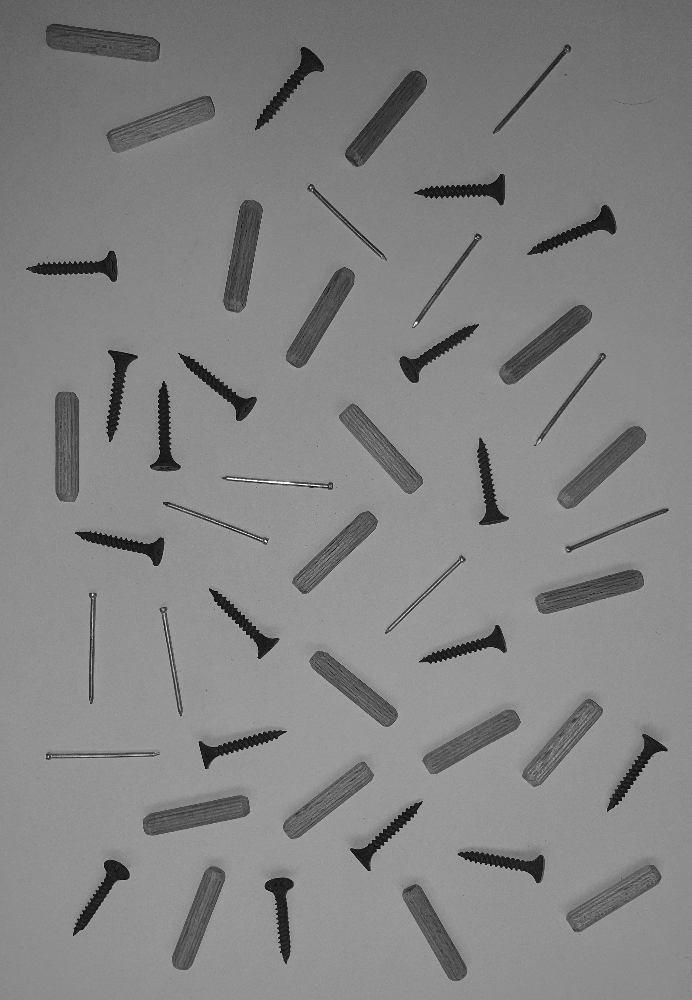

(3101, 2148)


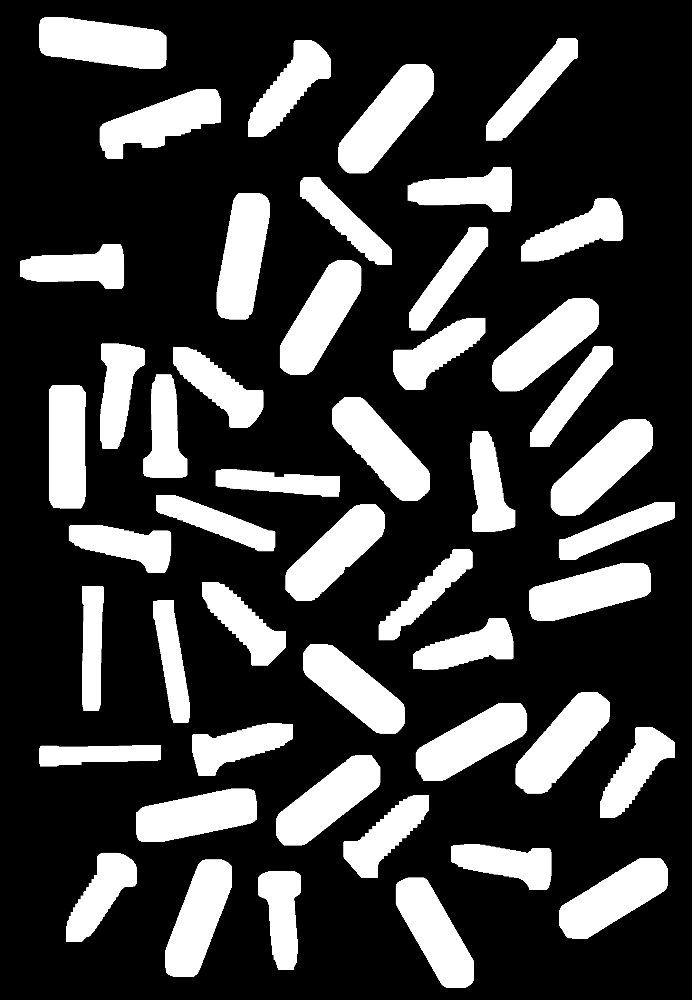

Number of objects: 48


In [63]:
import cv2
import skimage.io
import skimage.filters
import numpy as np

img = cv.imread('recognition.jpg')
img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
show(img,1000)

print(np.shape(img))

# Apply Sauvola thresholding
window_size = 1001
thresh_sauvola = skimage.filters.threshold_sauvola(img, window_size=window_size)
binary_sauvola = img > thresh_sauvola

# Convert to uint8
binary = np.uint8(~(binary_sauvola * 255))

# Create structural elements for morphological operations
kernel_closing = np.ones((5, 5), np.uint8)
kernel_dilation = np.ones((15, 15), np.uint8)

# Apply morphological closing
binary = cv2.dilate(cv2.erode(binary, kernel_closing), kernel_closing)

# Apply dilation
binary = cv2.dilate(binary, kernel_dilation, iterations=3)

show(binary,1000)

# Find contours using OpenCV
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Count the contours
num_contours = len(contours)

print(f"Number of objects: {num_contours}")